# sleept eyes detector (orign. img)

pip install imutils

pip install opencv-python

pip install dlib

## start

In [2]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

plt.style.use('dark_background')

## Load Dataset

In [4]:
x_train = np.load('dataset/x_train.npy').astype(np.float32)
y_train = np.load('dataset/y_train.npy').astype(np.float32)
x_val = np.load('dataset/x_val.npy').astype(np.float32)
y_val = np.load('dataset/y_val.npy').astype(np.float32)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_train.shape)

(2586, 26, 34, 1) (2586, 1)
(288, 26, 34, 1) (2586, 1)


## Preview

In [ ]:
plt.subplot(2, 1, 1)
plt.title(str(y_train[0]))
plt.imshow(x_train[0].reshape((26, 34)), cmap='gray')
plt.subplot(2, 1, 2)
plt.title(str(y_val[4]))
plt.imshow(x_val[4].reshape((26, 34)), cmap='gray')

## Data Augmentation

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(
    x = x_train, y = y_train, batch_size = 32, shuffle = True
)

val_generator = val_datagen.flow(
    x = x_val, y = y_val, batch_size = 32, shuffle = True
)

## Build model

In [8]:
inputs = Input(shape=(26, 34, 1))

net = Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(inputs)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = MaxPooling2D(pool_size=2)(net)

net = Flatten()(net)

net = Dense(512)(net)
net = Activation('relu')(net)
net = Dense(1)(net)
outputs = Activation('sigmoid')(net)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 26, 34, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 34, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 17, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 17, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 8, 128)         73856 

2023-04-17 16:58:17.878802: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-17 16:58:18.802656: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13598 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:67:00.0, compute capability: 8.6
2023-04-17 16:58:18.803233: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14212 MB memory:  -> device: 1, name: NVIDIA RTX A4000, pci bus id: 0000:68:00.0, compute capability: 8.6


## Train

In [11]:
start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

model.fit_generator(
    train_generator, epochs=50, validation_data=val_generator,
    callbacks=[
        ModelCheckpoint('models/%s.h5' % (start_time), monitor='val_acc', save_best_only=True, mode='max', verbose=1),
        ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05)
    ]
)

Epoch 1/50


/tmp/ipykernel_150407/3027296455.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(
2023-04-17 17:01:16.630155: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8801
2023-04-17 17:01:18.006565: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-04-17 17:01:18.434143: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f3a2ff013f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-17 17:01:18.434166: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2023-04-17 17:01:18.434170: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): NVIDIA RTX A4000, Compute Capability 8.6
2023-04

79/81 [============================>.] - ETA: 0s - loss: 0.4802 - acc: 0.7581
Epoch 1: val_acc improved from -inf to 0.88889, saving model to models/2023_04_17_17_01_14.h5
81/81 [==============================] - 7s 23ms/step - loss: 0.4759 - acc: 0.7614 - val_loss: 0.2533 - val_acc: 0.8889 - lr: 0.0010
Epoch 2/50
79/81 [============================>.] - ETA: 0s - loss: 0.2174 - acc: 0.9148
Epoch 2: val_acc improved from 0.88889 to 0.95139, saving model to models/2023_04_17_17_01_14.h5
81/81 [==============================] - 2s 20ms/step - loss: 0.2156 - acc: 0.9153 - val_loss: 0.1002 - val_acc: 0.9514 - lr: 0.0010
Epoch 3/50
81/81 [==============================] - ETA: 0s - loss: 0.1466 - acc: 0.9505
Epoch 3: val_acc improved from 0.95139 to 0.96528, saving model to models/2023_04_17_17_01_14.h5
81/81 [==============================] - 2s 21ms/step - loss: 0.1466 - acc: 0.9505 - val_loss: 0.0853 - val_acc: 0.9653 - lr: 0.0010
Epoch 4/50
80/81 [============================>.] - ETA: 

## Confusion Matrix

9/9 [==============================] - 0s 2ms/step
test acc: 1.0


/tmp/ipykernel_150407/1472568577.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pred_logical = (y_pred > 0.5).astype(np.int)


<Axes: >

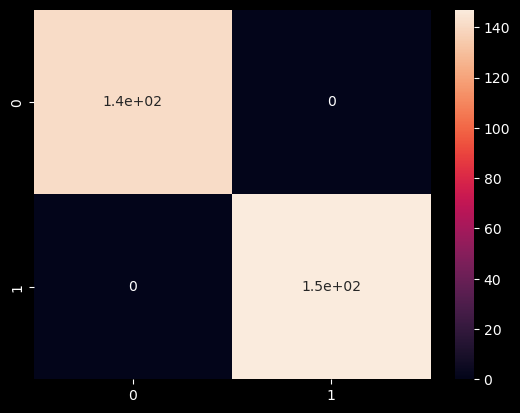

In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

model = load_model('models/%s.h5' % (start_time))

y_pred = model.predict(x_val/255.)
y_pred_logical = (y_pred > 0.5).astype(np.int)

print('test acc: %s' % accuracy_score(y_val, y_pred_logical))
cm = confusion_matrix(y_val, y_pred_logical)
sns.heatmap(cm, annot=True)

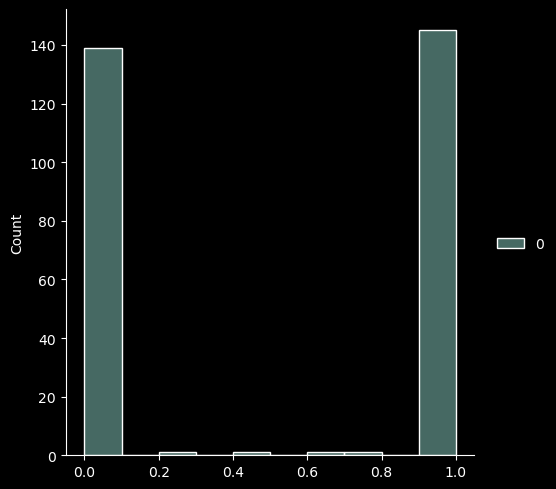

In [14]:
ax = sns.displot(y_pred, kde=False)